<a href="https://colab.research.google.com/github/DatawizzAI/DatawizzAI/blob/main/Fine_Tuned_Llama_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Libraries

In [1]:
# Install necessary libraries
!pip install -q transformers datasets accelerate peft trl bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.3 MB/s eta 0:00:00


# Logging into Hugging Face

In [2]:
from huggingface_hub import notebook_login

# Log in to your Hugging Face account
notebook_login()


# Loading the Model and Tokenizer

## Selecting the Model

In [3]:
model_name = "meta-llama/Llama-3.2-1B-Instruct"

## Loading the model

In [4]:
import torch
# Set torch dtype and attention implementation
if torch.cuda.get_device_capability()[0] >= 8:
  #Choosing the right math:
  #The code first checks if your computer's graphics card (GPU) is new and powerful enough. If it is, it installs a special tool called "flash-attn" that can do math really fast.
    !pip install -qqq flash-attn
    torch_dtype = torch.bfloat16
    attn_implementation = "flash_attention_2"
else:
  #Setting up the calculator:
  #Depending on your GPU, the code chooses how precise the math should be. It's like choosing between a basic calculator (float16) and a fancier one (bfloat16).
    torch_dtype = torch.float16
    attn_implementation = "eager"

In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
#import torch

# Define label mappings
num_labels = 4
id2label = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
label2id = {v: k for k, v in id2label.items()}

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    attn_implementation = attn_implementation,
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/877 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-3.2-1B-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#

# Loading the Tokenizer

In [6]:
# Load the tokenizer
#tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="right")
tokenizer.pad_token = tokenizer.eos_token

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id  # or any other suitable token
model.config.pad_token_id = tokenizer.pad_token_id # Update model config to match



tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

# Preparing the Dataset

## Loading the Dataset

In [7]:
from datasets import load_dataset

# Load the AG News dataset
dataset = load_dataset("ag_news")


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

## Preprocessing

In [8]:
def preprocess_function(examples):
    return tokenizer(examples["text"],
                     truncation=True,
                     )

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

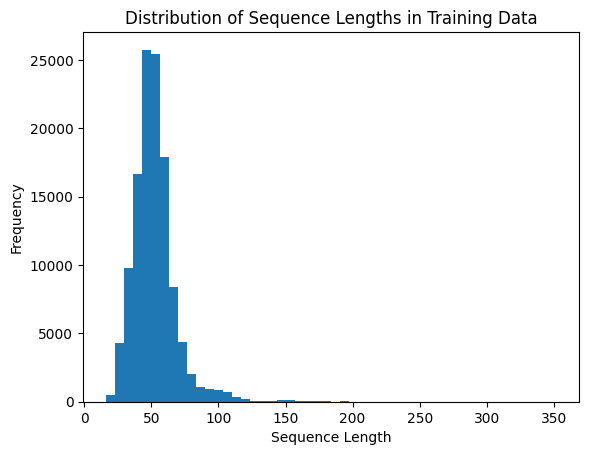

In [9]:
import matplotlib.pyplot as plt

# Assuming 'tokenized_dataset' is your dataset dictionary
train_dataset = tokenized_dataset["train"]

# Get the lengths of all sequences in the training dataset
sequence_lengths = [len(example["input_ids"]) for example in train_dataset]

# Create a histogram
plt.hist(sequence_lengths, bins=50)  # Adjust 'bins' for desired granularity
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths in Training Data")
plt.show()

In [10]:
max_seq_len = 128 # max(sequence_lengths)
print(max(sequence_lengths))

352


In [11]:
def preprocess_function(examples):
    return tokenizer(examples["text"],
                     truncation=True,
                     max_length=max_seq_len,  # Use max_seq_len for truncation
                     padding="max_length",  # Pad to max_seq_len if necessary
                     )

tokenized_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

## Data Collator

In [12]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


# Configuring LoRA for Fine-Tuning

## Setting Up LoRA

In [13]:
from peft import LoraConfig

peft_config = LoraConfig(
    task_type="SEQ_CLS",  # Sequence Classification
    inference_mode=False,
    r=16,                 # Rank of LoRA matrices
    lora_alpha=32,        # Scaling factor
    lora_dropout=0.1,     # Dropout rate
    #target_modules=["q_proj", "v_proj"]  # Modules to apply LoRA
    target_modules="all-linear", #modules,
)



# Training the Model

## Setting Hyperparameters

In [21]:
from transformers import TrainingArguments

training_arguments = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,  # You can increase this for better performance
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=500,
    logging_steps=100,
    learning_rate=5e-5,
    fp16=True,  # Use mixed precision
    report_to="none",  # Disable logging to external services
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## Defining Metrics

In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}


## Initializing the Trainer

In [23]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    train_dataset=tokenized_dataset["train"].shuffle(seed=42),#.select(range(50000)),
    eval_dataset=tokenized_dataset["test"].shuffle(seed=42).select(range(500)),
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    packing= False # Set packing to False to explicitly control padding strategy
)



/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


# Training

In [24]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.211800,0.271428,0.894000,0.894727,0.898480,0.894000
1000,0.187500,0.256102,0.906000,0.906303,0.907105,0.906000
1500,0.180500,0.219289,0.906000,0.906070,0.906318,0.906000
2000,0.157300,0.239036,0.904000,0.904623,0.910333,0.904000
2500,0.154100,0.202151,0.922000,0.922651,0.924742,0.922000
3000,0.163900,0.204750,0.918000,0.918491,0.920116,0.918000
3500,0.163300,0.200412,0.924000,0.924393,0.925131,0.924000


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


TrainOutput(global_step=3750, training_loss=0.1901584425608317, metrics={'train_runtime': 5922.4589, 'train_samples_per_second': 20.262, 'train_steps_per_second': 0.633, 'total_flos': 9.072550084608e+16, 'train_loss': 0.1901584425608317, 'epoch': 1.0})

# Evaluating the Model

In [25]:
#metrics = trainer.evaluate()
#print(metrics)

# Evaluate on the entire test dataset after training
eval_results = trainer.evaluate(eval_dataset=tokenized_dataset["test"].select(range(500)))
print(eval_results)

{'eval_loss': 0.15590718388557434, 'eval_accuracy': 0.95, 'eval_f1': 0.9499685346115099, 'eval_precision': 0.95019754184494, 'eval_recall': 0.95, 'eval_runtime': 11.1544, 'eval_samples_per_second': 44.825, 'eval_steps_per_second': 2.869, 'epoch': 1.0}


In [26]:
# Evaluate on the entire test dataset after training
eval_results = trainer.evaluate(eval_dataset=tokenized_dataset["test"])
print(eval_results)

{'eval_loss': 0.16011320054531097, 'eval_accuracy': 0.9496052631578947, 'eval_f1': 0.9495957378250849, 'eval_precision': 0.9495878681631021, 'eval_recall': 0.9496052631578947, 'eval_runtime': 164.9781, 'eval_samples_per_second': 46.067, 'eval_steps_per_second': 2.879, 'epoch': 1.0}


# Inference

In [27]:
import torch

# Select a sample from the test set
i = 5000
text = dataset['test']['text'][i]

# Tokenize and prepare inputs
inputs = tokenizer(text, return_tensors="pt", truncation=True).to(model.device)

# Get predictions
with torch.no_grad():
    logits = model(**inputs).logits

# Get the predicted class
predicted_class_id = logits.argmax().item()
predicted_label = model.config.id2label[predicted_class_id]
actual_label = model.config.id2label[dataset['test']['label'][i]]

print(f"Text: {text}")
print(f"Predicted Label: {predicted_label}")
print(f"Actual Label: {actual_label}")


Text: Toyota #39;s quarterly profit drops Toyota Motor Corporation, the world #39;s second-largest carmaker, had an unexpected drop in quarterly profit as investment earnings declined at a truckmaking unit and a stronger yen cut the value of overseas sales.
Predicted Label: Business
Actual Label: Business
